# Implementation of CRF  for NER

In [61]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import random
from sklearn.feature_extraction import DictVectorizer
import pprint
pp = pprint.PrettyPrinter(indent=4)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import scipy.stats
from sklearn.model_selection import cross_val_predict, cross_val_score



from sklearn_crfsuite import CRF, scorers, metrics
from sklearn_crfsuite.metrics import flat_classification_report

from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import RandomizedSearchCV
import eli5





In [6]:
data = pd.read_csv("ner.csv", encoding = "ISO-8859-1", error_bad_lines=False)


b'Skipping line 281837: expected 25 fields, saw 34\n'


In [7]:
data.dropna(inplace=True)

In [9]:
df=pd.DataFrame({'word':data.word,'tag':data.tag,'pos':data.pos})

In [ ]:

""" vectorizer = DictVectorizer(sparse=False)
x = vectorizer.fit_transform(df[0:5000].to_dict("records"))

x.shape """


In [10]:
df.reset_index(drop=True,inplace=True)

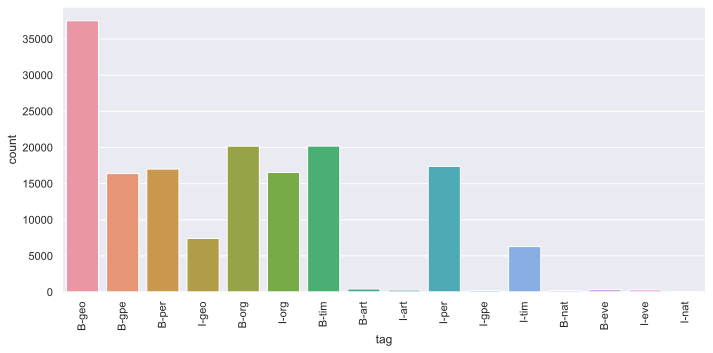

In [11]:
plt.figure(figsize=(10,5))
ax = sns.countplot('tag', data=df.loc[df['tag'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

# CRF

In [18]:
def word2features(df, size):
    X = []
    y = []
    cnt = 0
    i=0
    while i < size-1:
        temp = []
        temp1 = []
        while (df.word[i] != '.') & (i + 1 < size):
            if i%100000==0:
                print("---Done upto {} index---".format(i))
            word = df.word[i]
            postag = df.pos[i]

            features = {
                'bias': 1.0,
                'word.lower()': word.lower(),
                'word[-3:]': word[-3:],
                'word[-2:]': word[-2:],
                'word.isupper()': word.isupper(),
                'word.istitle()': word.istitle(),
                'word.isdigit()': word.isdigit(),
                'postag': postag,
                'postag[:2]': postag[:2],
            }
            if i > 0:
                word1 = df.word[i - 1]
                postag1 = df.pos[i - 1]
                features.update({
                    '-1:word.lower()': word1.lower(),
                    '-1:word.istitle()': word1.istitle(),
                    '-1:word.isupper()': word1.isupper(),
                    '-1:postag': postag1,
                    '-1:postag[:2]': postag1[:2],
                })
            else:
                features['BOS'] = True

            if df.word[i + 1] == '.':
                features['EOS'] = True
            else:
                word1 = df.word[i + 1]
                postag1 = df.pos[i + 1]
                features.update({
                    '+1:word.lower()': word1.lower(),
                    '+1:word.istitle()': word1.istitle(),
                    '+1:word.isupper()': word1.isupper(),
                    '+1:postag': postag1,
                    '+1:postag[:2]': postag1[:2],
                })

            temp.append(features)
            temp1.append(df.tag[i])
            i += 1
        i+=1
        cnt += 1
        X.append(temp)
        y.append(temp1)
    return X, y, cnt

In [19]:
X, y, cnt = word2features(df, len(df))

---Done upto 0 index---
---Done upto 100000 index---
---Done upto 300000 index---
---Done upto 400000 index---
---Done upto 500000 index---
---Done upto 600000 index---
---Done upto 700000 index---
---Done upto 800000 index---
---Done upto 900000 index---
---Done upto 1000000 index---


In [20]:
cnt

47896

In [21]:
crf = CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

In [22]:
pred = cross_val_predict(estimator=crf, X=X, y=y, cv=5)
report = flat_classification_report(y_pred=pred, y_true=y)
print(report)

              precision    recall  f1-score   support

       B-art       0.80      0.50      0.62       434
       B-eve       0.74      0.62      0.68       348
       B-geo       0.87      0.92      0.90     37525
       B-gpe       0.97      0.93      0.95     16392
       B-nat       0.73      0.47      0.57       226
       B-org       0.84      0.78      0.81     20184
       B-per       0.89      0.86      0.87     17011
       B-tim       0.94      0.90      0.92     20193
       I-art       0.71      0.47      0.57       280
       I-eve       0.69      0.58      0.63       297
       I-geo       0.85      0.87      0.86      7409
       I-gpe       0.85      0.52      0.64       229
       I-nat       0.62      0.46      0.53        76
       I-org       0.87      0.85      0.86     16537
       I-per       0.89      0.92      0.90     17382
       I-tim       0.88      0.82      0.85      6298
           O       0.99      1.00      0.99    842077

    accuracy              

In [23]:
##Taking tag values for weighted f1_score excluding 'O' since it has a huge bias 

labels = list(set(df.tag))
labels.remove('O')

In [24]:
crf = CRF(algorithm='lbfgs',
          max_iterations=100,
          all_possible_transitions=False)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted',
                        labels=labels)

rs = RandomizedSearchCV(crf,
                        params_space,
                        cv=5,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=10,
                        scoring=f1_scorer)
rs.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 20.

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=False, averaging=None,
                                 c=None, c1=None, c2=None,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None, gamma=None,
                                 keep...
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002208B93BB88>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False,
                   scoring=make_scorer(flat_f1_score, average=weighte

In [25]:
print('Best parameters:', rs.best_params_)
print('Best CV score:', rs.best_score_)
print('Model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

Best parameters: {'c1': 0.07885415411477302, 'c2': 0.025178001956116067}
Best CV score: 0.8854540212197344
Model size: 3.00M


In [26]:
crf = rs.best_estimator_
y_pred = crf.predict(X)
print(metrics.flat_classification_report(y, y_pred, labels=labels, digits=3))

              precision    recall  f1-score   support

       B-geo      0.918     0.959     0.938     37525
       I-geo      0.920     0.943     0.931      7409
       I-art      0.949     0.864     0.905       280
       B-tim      0.966     0.941     0.953     20193
       I-eve      0.931     0.822     0.873       297
       I-per      0.952     0.960     0.956     17382
       I-tim      0.937     0.917     0.927      6298
       I-nat      0.851     0.829     0.840        76
       B-nat      0.883     0.704     0.783       226
       B-org      0.930     0.879     0.904     20184
       B-gpe      0.984     0.949     0.966     16392
       B-eve      0.909     0.836     0.871       348
       I-gpe      0.924     0.694     0.793       229
       B-art      0.949     0.859     0.902       434
       I-org      0.964     0.947     0.956     16537
       B-per      0.954     0.944     0.949     17011

   micro avg      0.945     0.939     0.942    160821
   macro avg      0.933   

In [27]:
eli5.show_weights(crf, top=30)

From \ To,O,B-art,I-art,B-eve,I-eve,B-geo,I-geo,B-gpe,I-gpe,B-nat,I-nat,B-org,I-org,B-per,I-per,B-tim,I-tim
O,4.643,1.127,0.0,1.581,0.0,1.838,0.0,1.158,0.0,0.415,0.0,2.652,0.0,2.522,0.0,2.709,0.0
B-art,-0.331,0.0,8.597,0.0,0.0,-0.96,0.0,0.0,0.0,0.0,0.0,1.08,0.0,-2.533,0.0,-0.586,0.0
I-art,-1.653,0.0,8.349,0.0,0.0,0.159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.947,0.0,-0.834,0.0
B-eve,-0.412,0.0,0.0,0.0,9.84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.435,0.0
I-eve,-0.007,0.0,0.0,0.0,8.582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B-geo,0.66,1.576,0.0,0.0,0.0,-4.289,8.633,0.193,0.0,0.0,0.0,0.687,0.0,-2.078,0.0,1.86,0.0
I-geo,-0.038,0.987,0.0,0.0,0.0,0.0,7.781,-1.044,0.0,0.0,0.0,0.185,0.0,-0.666,0.0,1.202,0.0
B-gpe,1.272,-0.498,0.0,-0.048,0.0,0.554,0.0,0.0,9.307,0.0,0.0,2.909,0.0,-0.071,0.0,0.64,0.0
I-gpe,-0.229,0.0,0.0,0.0,0.0,-1.264,0.0,0.0,8.729,0.0,0.0,0.0,0.0,-0.584,0.0,0.0,0.0
B-nat,-0.09,0.0,0.0,0.0,0.0,0.773,0.0,0.0,0.0,0.0,7.771,0.0,0.0,-2.008,0.0,0.414,0.0
